# Library

In [1]:
!pip install torchinfo

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, Subset

from torchinfo import summary

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import os

from sklearn.metrics import classification_report , confusion_matrix , accuracy_score

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(42)
if device == 'cuda':
    torch.cuda.manual_seed_all(42)

# Data Information

In [4]:
TRAIN_DIR = '/content/drive/MyDrive/DATASET/Images /Asian Vs Africa/dataset/train'
TEST_DIR = '/content/drive/MyDrive/DATASET/Images /Asian Vs Africa/dataset/test'

# Data Preprocessing

## Transforms

In [5]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()

])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

## Datasets

In [6]:
def create_datasets(train_dir, test_dir, train_transforms = None, test_transforms = None):
    train_data = datasets.ImageFolder(train_dir, transform=train_transforms)
    test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

    return train_data, test_data

train_ds , test_ds = create_datasets(TRAIN_DIR, TEST_DIR, train_transforms , test_transforms)

## Data Loader

In [7]:
def create_dataloaders(train_ds, test_ds, batch_size = 32):
    train_dataloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = create_dataloaders(train_ds, test_ds)

### Display Images

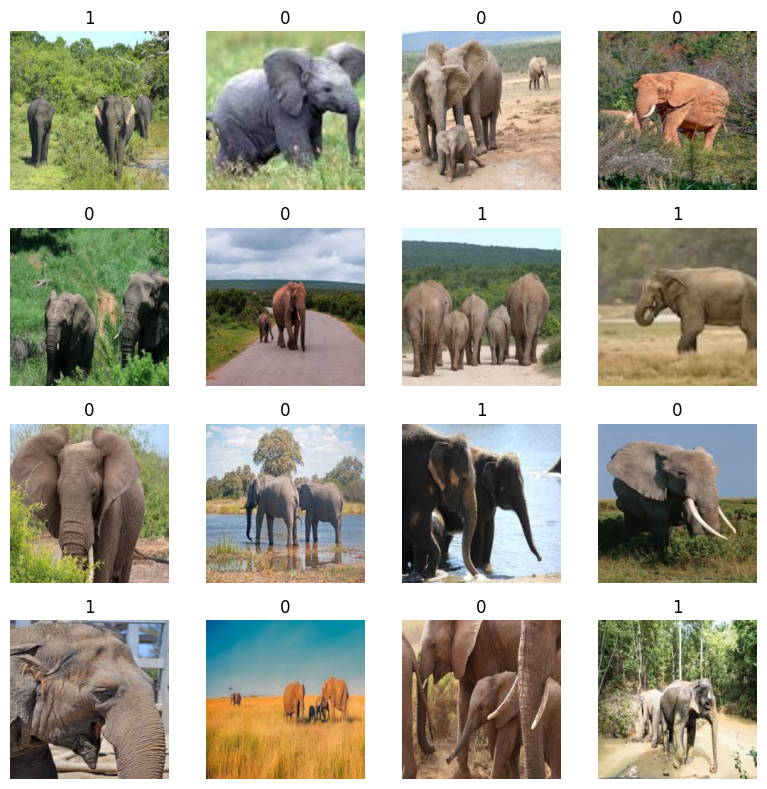

In [8]:
images, labels = next(iter(train_dataloader))

num_images = len(images)

fig, axes = plt.subplots(4, 4, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
  if i < num_images:
    ax.imshow(images[i].permute(1, 2, 0).numpy())
    ax.set_title(labels[i].item())
    ax.axis("off")

plt.tight_layout()
plt.show()

# Data Modeling

## Architecture

In [9]:
class CNN(nn.Module):
  def __init__(self, input_channels, hidden_units, output_classes):
    super().__init__()

    self.block_1 = nn.Sequential(
      nn.Conv2d(in_channels=input_channels, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2),
      nn.AdaptiveAvgPool2d((7, 7))
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units * 7 * 7,out_features= hidden_units),
      nn.Linear(in_features=hidden_units,out_features=output_classes)
    )

  def forward(self, x):
    x  = self.block_1(x)
    x = self.classifier(x)
    return x

## Function

In [10]:
def train_one_epoch(dl , model , loss_fn , optmzr , lr_scheduler):
    train_loss , train_acc = 0 , 0
    model.train()
    for batch , (x,y) in enumerate(dl):
        x,y = x.to(device),y.to(device)

        preds = model(x)
        loss = loss_fn(preds , y)
        train_loss += loss.item()

        optmzr.zero_grad()
        loss.backward()
        optmzr.step()

        pred_classes = torch.argmax(torch.softmax(preds,dim = 1) , dim = 1)
        train_acc += torch.sum(pred_classes == y).cpu().item() / len(y)
    lr_scheduler.step()
    return train_acc / len(dl) , train_loss / len(dl)

def validate(dl , model , loss_fn):
    val_loss , val_acc = 0 , 0
    model.eval()
    with torch.inference_mode():
        for batch , (x,y) in enumerate(dl):
            x, y = x.to(device) , y.to(device)
            preds = model(x)
            loss = loss_fn(preds , y)
            val_loss += loss.item()
            pred_classes = torch.argmax(torch.softmax(preds , dim = 1) , dim = 1)
            val_acc += torch.sum(pred_classes == y).cpu().item() / len(y)
    return val_acc / len(dl) , val_loss / len(dl)

In [11]:
learning_rate = 1e-3
num_epochs = 10

logs = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}

model = CNN(input_channels=3, hidden_units=16, output_classes=10).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    train_acc, train_loss = train_one_epoch(train_dataloader, model, loss_fn, optimizer, scheduler)
    print(f"Train Accuracy: {train_acc:.4f}, Train Loss: {train_loss:.4f}")

    val_acc, val_loss = validate(test_dataloader, model, loss_fn)
    print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")

    logs['train_acc'].append(train_acc)
    logs['val_acc'].append(val_acc)
    logs['train_loss'].append(train_loss)
    logs['val_loss'].append(val_loss)

    print("-" * 30)

print("Training Completed.")

Epoch 1/10
Train Accuracy: 0.5012, Train Loss: 1.2531
Validation Accuracy: 0.5052, Validation Loss: 0.7831
------------------------------
Epoch 2/10
Train Accuracy: 0.5370, Train Loss: 0.7105
Validation Accuracy: 0.4948, Validation Loss: 0.6966
------------------------------
Epoch 3/10
Train Accuracy: 0.5521, Train Loss: 0.6922
Validation Accuracy: 0.5268, Validation Loss: 0.6804
------------------------------
Epoch 4/10
Train Accuracy: 0.5683, Train Loss: 0.6817
Validation Accuracy: 0.6339, Validation Loss: 0.6572
------------------------------
Epoch 5/10
Train Accuracy: 0.5995, Train Loss: 0.6725
Validation Accuracy: 0.6161, Validation Loss: 0.6466
------------------------------
Epoch 6/10
Train Accuracy: 0.5775, Train Loss: 0.6791
Validation Accuracy: 0.6771, Validation Loss: 0.6426
------------------------------
Epoch 7/10
Train Accuracy: 0.6030, Train Loss: 0.6633
Validation Accuracy: 0.6124, Validation Loss: 0.6486
------------------------------
Epoch 8/10
Train Accuracy: 0.5984,

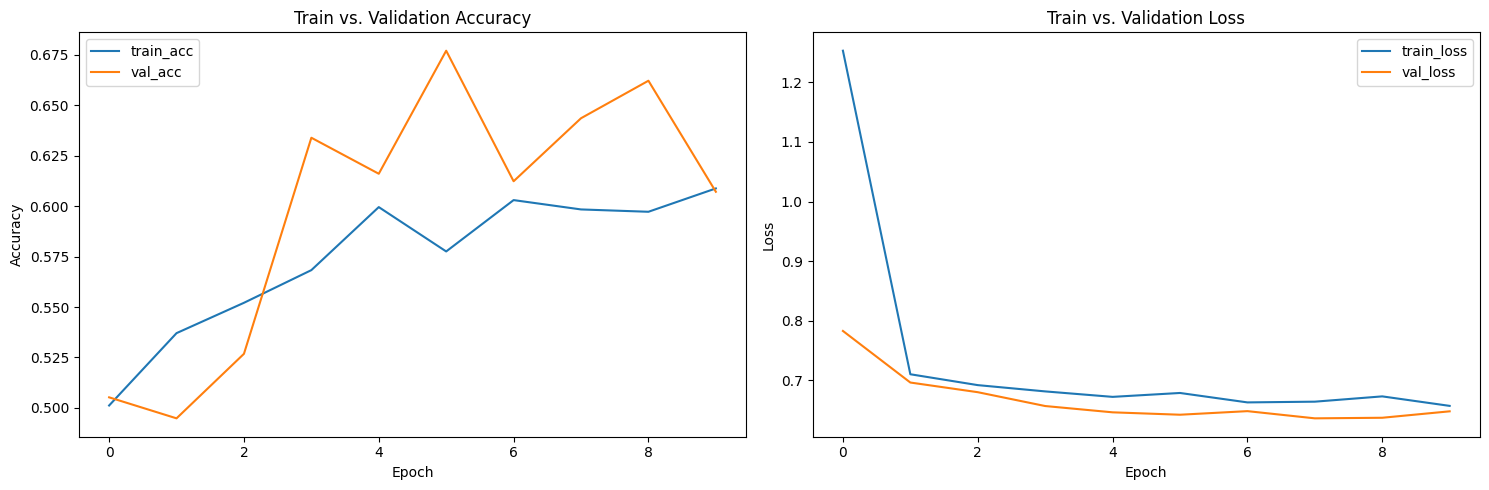

In [12]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(logs['train_acc'], label='train_acc')
plt.plot(logs['val_acc'], label='val_acc')
plt.title('Train vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(logs['train_loss'], label='train_loss')
plt.plot(logs['val_loss'], label='val_loss')
plt.title('Train vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

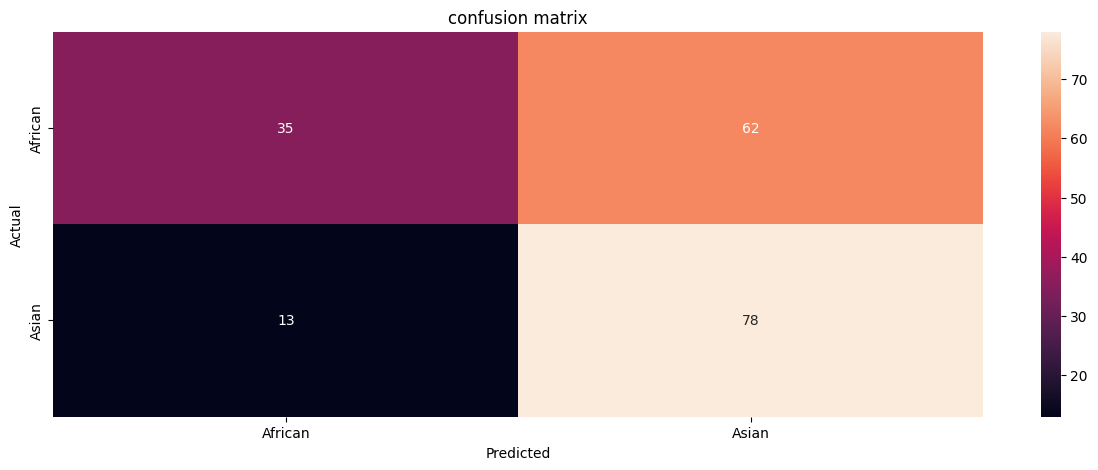

In [13]:
y_true , y_predicted = [] , []
paths_to_check = []

model.eval()
with torch.inference_mode():
    for batch , (x,y) in enumerate(test_dataloader):
        x,y = x.to(device),y.to(device)

        preds = model(x)
        pred_classes = torch.argmax(torch.softmax(preds , dim = 1) , dim = 1)

        y_predicted.extend(pred_classes.cpu().numpy())
        y_true.extend(y.cpu().numpy())


y_true , y_predicted = np.array(y_true) ,np.array(y_predicted)
cm = confusion_matrix(y_true , y_predicted)
label_list = test_ds.classes
plt.figure(figsize = (15 , 5))
ax=plt.subplot()
sns.heatmap(cm , annot = True , fmt='g' ,ax = ax,xticklabels=label_list,yticklabels=label_list)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title("confusion matrix")
plt.show()